# Analyse der Tweets von Bundestagsabgeordneten
## 1. Dataset preparation

In [1]:
import pymongo

client = pymongo.MongoClient("mongodb://localhost:27017/")

db = client['Twitter']
All_Tweets_collection = db['twitter_mdp_ex_date_proj']


In [2]:
import pandas as pd
import pymongo
import datetime

pd.set_option('display.max_colwidth', 0)

# sample_df = pd.DataFrame(list(All_Tweets_collection.aggregate([ {"$sample": {"size": 50 }}], 
#                                      allowDiskUse=True
#                                    )))

time_sample_df = pd.DataFrame(list(All_Tweets_collection.find( {
            'created_at_datetime': {'$gte': datetime.datetime(2019,5,1,0,0,0),
                                    '$lt': datetime.datetime(2020,5,31,0,0,0)},
            'retweeted_id': None
            })
        ))

##### Text Cleaning

In [3]:
# Load the regular expression library
pd.set_option('display.max_colwidth', 0)
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F900-\U0001F9FF"  # https://www.compart.com/de/unicode/block/U+1F900
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string)

sample_df = time_sample_df
# Remove punctuation
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text')].map(lambda x: re.sub('[,\.!?#@\\n"“„\:;&\(\)]', '', x))

# Remove Links
sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('http.*', '', x))

sample_df.loc[:,('full_text_processed')] = sample_df.loc[:,('full_text_processed')].map(lambda x: re.sub('amp', '', x))

# Convert the titles to lowercase
sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: x.lower())

#sample_df['full_text_processed'] = sample_df['full_text_processed'].map(lambda x: remove_emoji(x))
# Print out the first rows of papers
# sample_df['full_text_processed'].head(10)

In [220]:
date = []
for timestamp in sample_df.created_at_datetime:
    date.append(timestamp.date())
      
sample_df.loc[:, ('date')] = date
sample_df.loc[:,('month')] = sample_df.created_at_datetime.dt.strftime('%y-%m')
sample_df.loc[:,('week')] = sample_df.created_at_datetime.dt.strftime('%y-w%U')

##### Durchsuche Datensatz nach bestimmten Tweets und sortiere aus

In [ ]:
# Print words that match certain words:
#sample_df['full_text_processed'][sample_df['full_text_processed'].str.match(r'.*brexit.*')==True]

# Remove Tweets that match certain words:
# sample_df = sample_df[~sample_df.full_text_processed.str.contains("fröhlicher gruss")]
# sample_df.groupby('user_party').size()

##### Stopwords

In [221]:
#from stop_words import get_stop_words
#stop_words = get_stop_words('de')

import stopwordsiso as stopwords
stop_words = list(stopwords.stopwords(["de"])) 

mehr_sw = ['der', 'die', 'das', 'Das', 'the', 'ist' 'es', 'gibt', 'und', 'für', 'auf', 'aus', 'mit', 'dem', 'tb', 'cducsubt', 'spdbt', 'fdpbt', 'sdpde']
for word in mehr_sw:
    stop_words.append(word)
    


#### Wordcloud Gegenüberstellung von Parteien

In [222]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from wordcloud import WordCloud
sent_ReEx = sample_df
#sent_ReEx = sample_df[sample_df['full_text_processed'].str.match(r'(.*Corona.*|.*Covid.*|.*berlin.*|.*deutsch.*|.*bundes.*)(?i)')==False]

sample_df_date = sent_ReEx.loc[(sent_ReEx['date'] >= datetime.date(2020,3,8))
                              & (sent_ReEx['date'] <= datetime.date(2020,5,31))
                              ]

partei_dic_date = {}
for partei in parteien:
    partei_dic_date['tweets_'+ partei] = sample_df_date[sample_df['user_party'] == partei]  


def FktWordCloud(long_string):
    wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', stopwords=stop_words, min_word_length=3)
    wordcloud.generate(long_string)
    wordcloud.to_image()
    return wordcloud

fig = plt.figure(figsize = (16, 16))
#fig.subplots_adjust(top=0.8)

for partei, n in zip(partei_dic_date, range(1,7)):
    title = str(partei)
    
    ax = fig.add_subplot(5,3,n)
    ax.set_title(title,fontweight="bold", color='navy', size=20)
    fig.tight_layout()
    sample_df_partei=partei_dic_date[partei]
    long_string = ','.join(sample_df_partei['full_text_processed'])
    wordcloud = FktWordCloud(long_string)
    ax.imshow(wordcloud)
    ax.axis('off')
fig.suptitle('Tweets 8. Mai ohne Corona', fontsize=25, color='navy', y=1.05)

NameError: name 'parteien' is not defined

In [ ]:
sample_df[sample_df['date'] == datetime.date(2020,5,8)]

# Sentiment Analyse - Wörterbuch
## Simple TextBlob Analysis

In [140]:
#import nltk
#nltk.download('punkt')
from textblob_de import TextBlobDE as TextBlob

blob = TextBlob(sample_df.full_text_processed[33504]) 

print(blob.sentences)
print(blob.tokens)
print(blob.tags)
print(blob.noun_phrases)
print(blob.sentiment)

[Sentence("lesestoff 📖")]
['lesestoff', '📖']
[('lesestoff', 'JJ'), ('📖', 'NN')]
[]
Sentiment(polarity=0.0, subjectivity=0.0)


#### Erstellen des DataFrame bzw. laden mit Pickle

In [15]:
# # https://medium.com/@himanshu_23732/sentiment-analysis-with-textblob-6bc2eb9ec4ab
# def sentiment(text):
#     try:
#         return TextBlob(text).sentiment
#     except:
#         return None
    
# sample_df['Polarity']     = sample_df['full_text_processed'].apply(sentiment).apply(lambda x: x[0])
# sample_df['Subjectivity'] = sample_df['full_text_processed'].apply(sentiment).apply(lambda x: x[1])
# sample_df.head()

In [141]:
import pickle, gensim, numpy as np
# pickle.dump(sample_df, open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Sent_TextBlob', "wb" ))
sample_df = pickle.load(open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Sent_TextBlob', "rb" ))

#### Übersetzen von 'Polarity' in Categorie

In [142]:
# compute sentiment scores (polarity) and labels
sentiment_scores = sample_df['Polarity']
sample_df['category'] = ['positive' if score > 0 
                             else 'negative' if score < 0 
                                 else 'neutral' 
                                     for score in sentiment_scores]

## Darstellung von Ergebnissen

In [143]:
import pandas as pd
mdp_partei_TB = sample_df[['user_party', 'month', 'date', 'user_screen_name', 'full_text', 'category']]
#mdp_partei = mdp_partei.loc[(mdp_partei['predict'] == 'OFFENSE') & (mdp_partei['date'] >= datetime.date(2019,10,25))]
partei_piv_TB = pd.pivot_table(mdp_partei_TB, columns = ['category'], index = ['user_party'], aggfunc = np.count_nonzero)
partei_piv_TB['full_text']

category,negative,neutral,positive
user_party,,,
AFD,4797,10720,6427
FDP,6355,19823,13983
Gruene,4792,16824,12342
Linke,6504,14780,9813
SPD,4287,18769,14990
Union,4235,16513,13144


In [147]:
mdp_partei = sample_df[['user_party', 'month', 'week', 'date', 'user_screen_name', 'full_text', 'category']]

mdp_partei_nom = mdp_partei.loc[(mdp_partei['category'] == 'positive') & (mdp_partei['date'] >= datetime.date(2019,10,25))]
partei_piv_TB_nom = pd.pivot_table(mdp_partei_nom, columns = ['user_party'], index = ['week'], aggfunc = np.count_nonzero)
partei_piv_TB_nom = partei_piv_TB_nom['date']

mdp_partei_denom = mdp_partei.loc[(mdp_partei['date'] >= datetime.date(2019,10,25))]
partei_piv_TB_denom = pd.pivot_table(mdp_partei_denom, columns = ['user_party'], index = ['week'], aggfunc = np.count_nonzero)
partei_piv_TB_denom = partei_piv_TB_denom['date']

partei_piv_TB_rel = (partei_piv_TB_nom/partei_piv_TB_denom) * 100
partei_piv_TB_rel = partei_piv_TB_rel.round()
# partei_piv_TB_rel

In [224]:
category

NameError: name 'category' is not defined

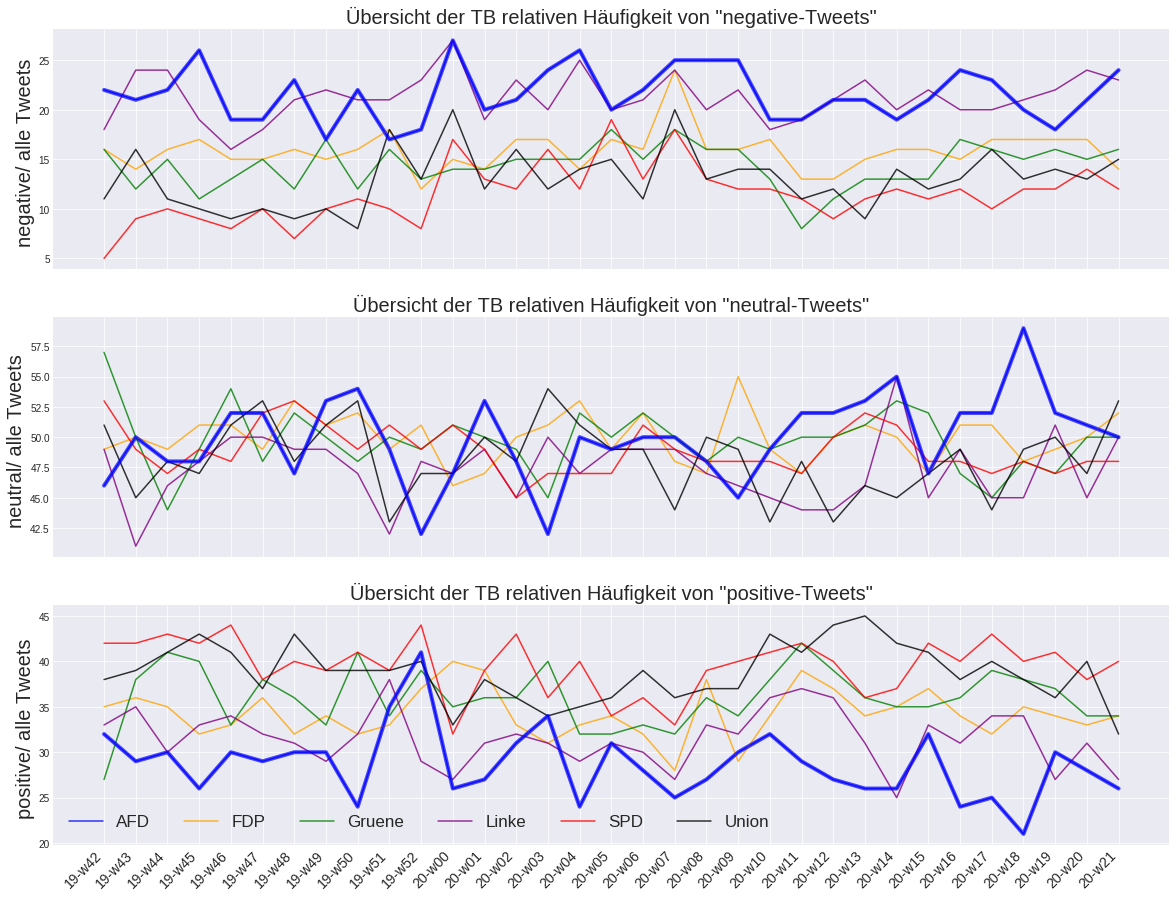

In [237]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

category = ['negative', 'neutral', 'positive']
mdp_partei = sample_df[['user_party', 'month', 'week', 'date', 'user_screen_name', 'full_text', 'category']]

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']

fig = plt.figure(figsize = (20, 15))

mdp_partei_denom = mdp_partei.loc[(mdp_partei['date'] >= datetime.date(2019,10,25))]
partei_piv_TB_denom = pd.pivot_table(mdp_partei_denom, columns = ['user_party'], index = ['week'], aggfunc = np.count_nonzero)
partei_piv_TB_denom = partei_piv_TB_denom['date']

for cat, n in zip(category, range(1,len(category)+1)):
    mdp_partei_nom = mdp_partei.loc[(mdp_partei['category'] == cat) & (mdp_partei['date'] >= datetime.date(2019,10,25))]
    partei_piv_TB_nom = pd.pivot_table(mdp_partei_nom, columns = ['user_party'], index = ['week'], aggfunc = np.count_nonzero)
    partei_piv_TB_nom = partei_piv_TB_nom['date']
    
    partei_piv_TB_rel = (partei_piv_TB_nom/partei_piv_TB_denom) * 100
    partei_piv_TB_rel = partei_piv_TB_rel.round()


###############  plot #################
    ax = fig.add_subplot(3,1,n)

    num=0
    for column in partei_piv_TB_rel:
        ax.plot(partei_piv_TB_rel.index, partei_piv_TB_rel[column], color = my_palette[num], alpha=0.8, label = column)
        num+=1

    ax.plot(partei_piv_TB_rel.index, partei_piv_TB_rel['AFD'], marker='', color='blue', linewidth=4, alpha=0.7)

    ax.set_title('Übersicht der TB relativen Häufigkeit von "' + cat + '-Tweets"', size = 20)
    ylab = ax.set_ylabel(cat +'/ alle Tweets ', size = 20)
    if n <= 2:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        x_tags = plt.xticks(partei_piv_TB_rel.index, fontsize = 14, rotation = 45, ha = "right")
        plt.legend(loc = 3, ncol = 6, fontsize = 17)




In [154]:
# pd.set_option('display.max_colwidth', None)

# sample_df.loc[(sample_df['category'] == 'neutral')
#              & (sample_df['user_party'] == 'AFD')]['full_text']

In [ ]:
partei_dic_sent['sentiment_FDP']

## Basic Emotions
##### 1.) Erstellen der EmotionsMatrix

In dieser Matrix steht jede Zeile für ein deutsches Wort, welches den Wert 1 zugeschrieben bekommt, wenn eine der sieben "Basis Emotionen" damit verbunden ist.

In [5]:
%%time
import pandas as pd
from nltk import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from tqdm import tqdm


import csv
import numpy as np
import pandas as pd

pd.set_option('display.max_colwidth', 0)
    
######### Erstelle Emotions-Matrix

filepath = '/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Lexicon_based/german-emotion-dictionary/fundamental/'
emo_df = []
words = []
emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']
emotion_list= {}
stemmer = SnowballStemmer("german")

for emo in emotion:
    with open(filepath + emo + '.txt', newline='\n') as f:
        reader = csv.reader(f)
        data = [item for sublist in reader for item in sublist] 
        emotion_list[str(emo)] = data
        words.extend(data)
        
words = list(set(words)) # remove Duplicates which come from overlapping EmotionLists
emo_df  = pd.DataFrame(index=words, columns=emotion)

words = []
for word in emo_df.index:
    for emo in emo_df.columns:
        if word in emotion_list[emo]:
            emo_df.at[word, emo] = 1
        else:
            emo_df.at[word, emo] = 0
    words.append(stemmer.stem(word.lower()))
 
emo_df.index= words
emo_df = emo_df.sort_index(ascending=True)
emo_df = pd.DataFrame(emo_df)
emo_df = emo_df.loc[~emo_df.index.duplicated(keep='first')]

emo_df.head()


CPU times: user 814 ms, sys: 11.9 ms, total: 826 ms
Wall time: 829 ms


,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut
aalglatt,0,0,0,0,0,1,0
aasgei,0,0,0,0,0,1,0
abbrech,0,0,0,1,0,0,0
abbruchreif,0,0,0,0,0,1,0
abbugeln,0,0,0,0,0,1,0


##### Check ob bestimmtes Wort in Matrix enthalten ist

In [20]:
emo_df.loc[emo_df.index == 'ersticht']

,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut


#### 2.) Anwendung der Emotions Matrix auf den Twitter Datensatz
Jedes Wort in jedem Tweet wird in der Matrix gesucht und ggf. der Vektor zurückgegeben. 
Siehe Kommentare

In [156]:
# %%time
# emo_base_df = sample_df['full_text_processed']
# df_emo = pd.DataFrame(0, index=emo_base_df.index, columns=emotion)

# for i in emo_base_df.index:
#     document = word_tokenize(emo_base_df.loc[i])
#     for word in document:
#         word = stemmer.stem(word.lower())             # Stemming des einzelnen Wortes aus Tweet um es...
#         emo_score = emo_df[emo_df.index == word]      # ... mit den Lexikon Worten zu vergleichen -> emo_score 

#         if not emo_score.empty:                       # der emo score eines Worts z.B. [0 0 1 1 0 0 0] 
#             for emot in emotion:                      # wird zum Score des Tweets dazugezählt z.B.: [2 0 4 1 0 0 0]
#                 df_emo.at[i, emot] += emo_score[emot] # am Ende exisitiert zu einem Tweet ein 7-dim Vektor
                

# emo_base_df = pd.concat([emo_base_df, df_emo], axis=1)

# emo_base_df.head(20)

###### Füge 'id' hinzu um später den Vergleich mit anderen SentAn Methoden zu erleichtern

In [27]:
emo_sample_df = pd.concat([emo_base_df,sample_df['id']], axis = 1)
emo_sample_df.columns

Index(['full_text_processed', 'Ekel', 'Freude', 'Furcht', 'Trauer',
       'Ueberraschung', 'Verachtung', 'Wut', 'id'],
      dtype='object')

##### Speichere einfache Matrix (nicht relativ, aber mit id)

In [157]:
import pickle, gensim, numpy as np
#pickle.dump(emo_sample_df, open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/sent_basic_emo', "wb" ))
sent_basic_emo = pickle.load(open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/sent_basic_emo', "rb" ))

##### Bearbeite Columns um Darstellung später zu erleichtern

In [158]:
#### Add Timestamp
sent_basic_emo = emo_sample_df[['full_text_processed', 'Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut', 'id']]
sent_basic_emo[['user_party', 'month', 'week', 'date', 'user_screen_name']] = sample_df [['user_party', 'month', 'week', 'date', 'user_screen_name']]

sent_basic_emo.head(1)

,full_text_processed,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut,id,user_party,month,week,date,user_screen_name
0,kein mensch braucht umfaller/ fdp weder in der politik noch in den medien 🙄,0,0,0,0,0,0,0,1249634086966132742,AFD,20-04,20-w16,2020-04-13,StBrandner


##### Begrenze die Auswahl von relevanten Tweets -> emo_base_select

In [42]:
emo_base_select = emo_base_df
# emo_base_select = emo_base_df[emo_base_df['full_text_processed'].str.match(r'.*((?i)corona|(?i)Covid).*')==True]
# len(emo_base_select[emo_base_select['Partei']=='Gruene'])
# len(emo_base_select)

####  3.) Remove empty full_text_processed
Wenn z.B. nur ein Link und emojis gepostet wurden ist nach dem text cleaning die Zelle leer (aber nicht isnull() == true)

In [159]:
emo_base_text = sent_basic_emo.drop(emo_base_select[emo_base_select['full_text_processed']==''].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']==' '].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']=='  '].index)
emo_base_text = emo_base_text.drop(emo_base_text[emo_base_text['full_text_processed']=='   '].index)

In [160]:
emo_party = emo_base_text.groupby('user_party').sum()
emo_party.head()

,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut,id
user_party,,,,,,,,
AFD,493.0,5021.0,3243.0,3269.0,2462.0,8537.0,1961.0,2.599977e+22
FDP,635.0,9150.0,3984.0,5948.0,4701.0,10979.0,2186.0,4.807360e+22
Gruene,546.0,10450.0,3474.0,4834.0,4317.0,8053.0,2146.0,4.061990e+22
Linke,693.0,7417.0,4306.0,4922.0,3386.0,10759.0,2204.0,3.691770e+22
SPD,682.0,14024.0,3497.0,4959.0,3955.0,8559.0,1992.0,4.543888e+22


#### 4.) Relativieren von Werten
1.) Teile durch Länge (Wordcount) des Tweets => emo_base_rel

In [161]:
from nltk import tokenize
from nltk import word_tokenize

emo_base_rel=emo_base_text

emo_base_rel['word_count'] = emo_base_rel['full_text_processed'].apply(tokenize.word_tokenize).apply(len)

for emo in emotion:
    emo_base_rel[emo] = emo_base_rel[emo] / emo_base_rel['word_count']
emo_base_rel.head(2)

,full_text_processed,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut,id,user_party,month,week,date,user_screen_name,word_count
0,kein mensch braucht umfaller/ fdp weder in der politik noch in den medien 🙄,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,1249634086966132742,AFD,20-04,20-w16,2020-04-13,StBrandner,14
1,ganz einfachweil es zumal auf dauer niemals ein datenschutzgerechtes tool geben und das ein weiterer großer schritt richtung überwachungsstaat sein wirdich wünsche mir dringend etwas mehr problembewusstsein und kritische distanz beim datenschutzbeauftragten,0.0,0.0,0.03125,0.0,0.03125,0.0,0.0,1249631600658337793,AFD,20-04,20-w16,2020-04-13,StBrandner,32


2.) Teile durch die Menge der Tweets pro Partei => emo_party_rel

In [167]:
# 2.) Teilen durch Gesammtzahl an Tweets pro Partei #### umständliche aber korrekte Version
emo_party_sum = emo_base_rel.groupby('user_party').sum()
emo_party_count = emo_base_rel.groupby('user_party').count()
emo_party_rel = emo_party_sum/ emo_party_count
emo_party_rel

,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut,date,full_text_processed,id,month,user_screen_name,week,word_count
user_party,,,,,,,,,,,,,,
AFD,0.001042,0.011605,0.006071,0.006422,0.005694,0.017582,0.003816,NaN,NaN,1.200692e+18,NaN,NaN,NaN,22.409532
FDP,0.000675,0.012476,0.004049,0.006827,0.005182,0.012531,0.002168,NaN,NaN,1.202892e+18,NaN,NaN,NaN,22.001626
Gruene,0.000796,0.020338,0.004150,0.006273,0.006218,0.011283,0.002589,NaN,NaN,1.200174e+18,NaN,NaN,NaN,21.737893
Linke,0.001054,0.012873,0.005508,0.006411,0.005194,0.015095,0.002838,NaN,NaN,1.200185e+18,NaN,NaN,NaN,23.951040
SPD,0.000987,0.025058,0.003539,0.005689,0.005279,0.011218,0.002144,NaN,NaN,1.199865e+18,NaN,NaN,NaN,21.396224
Union,0.000724,0.020188,0.003265,0.005424,0.005520,0.011996,0.002170,NaN,NaN,1.198345e+18,NaN,NaN,NaN,21.608784


In [132]:
emo_party_count['id']['AFD']

21654

In [138]:
emo_base_rel.columns
emo_party_rel.columns

Index(['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung',
       'Wut', 'date', 'full_text_processed', 'id', 'month', 'user_screen_name',
       'week', 'word_count'],
      dtype='object')

## Darstellung von Ergebnissen nach Zeitabschnitten

In [249]:
import pandas as pd
mdp_partei_emo = emo_base_rel[['user_party', 'month', 'week', 'date', 'user_screen_name', 'full_text_processed',
                              'Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']]
#mdp_partei = mdp_partei.loc[(mdp_partei['predict'] == 'OFFENSE') & (mdp_partei['date'] >= datetime.date(2019,10,25))]
partei_piv_emo = pd.pivot_table(mdp_partei_emo, columns = ['user_party'], index = ['month'], aggfunc = np.count_nonzero)
# partei_piv_emo[['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']]
# partei_piv_emo

In [250]:
emotion = ['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']

partei_piv_emo_rel = partei_piv_emo[['Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']]
partei_piv_emo_denom = partei_piv_emo['user_screen_name']

for emo in emotion:
    partei_piv_emo_rel[emo] = partei_piv_emo[emo]/partei_piv_emo_denom

# partei_piv_emo_rel

/usr/local/anaconda3/bin/ipython:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from IPython import start_ipython


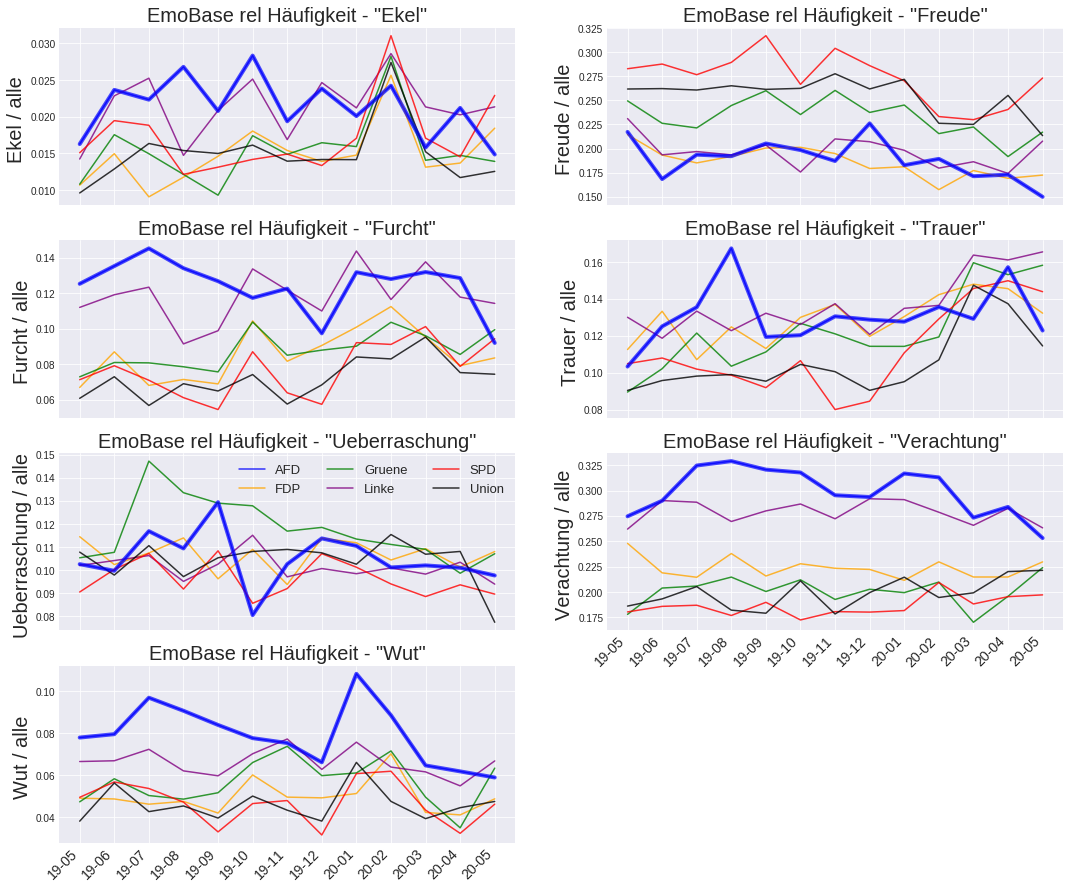

In [265]:
pd.set_option('display.max_rows', None)
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np

plt.style.use('seaborn-darkgrid')
my_palette = ['blue', 'orange', 'green', 'purple', 'red', 'black']
fig = plt.figure(figsize = (18, 15))
fig.tight_layout()


for emo, n in zip(emotion, range(1,len(emotion)+1)):
    ax = fig.add_subplot(4,2,n)
    
    num=0
    for column in partei_piv_emo_rel[emo]:
        ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo][column], color = my_palette[num], alpha=0.8, label = column)
        num+=1
    ax.plot(partei_piv_emo_rel.index, partei_piv_emo_rel[emo]['AFD'], marker='', color='blue', linewidth=4, alpha=0.7)
    ax.set_title('EmoBase rel Häufigkeit - "' +emo+ '"', size = 20)
    ylab = ax.set_ylabel(emo +' / alle ', size = 20)
    
    if n <= 5:
        plt.setp(ax.get_xticklabels(), visible=False)
    else:
        x_tags = plt.xticks(partei_piv_emo_rel.index, fontsize = 14, rotation = 45, ha = "right")
    if n == 5:
        plt.legend(loc = 1, ncol = 3, fontsize = 13)



# Vergleich der Label von konkreten Tweets
##### Laden der DataFrames

In [30]:
import pandas as pd
import datetime
import pickle, gensim, numpy as np

sent_df_Wien = pickle.load(open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/sent_df_Wien', "rb" ))
sent_df_TB = pickle.load(open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/Sent_TextBlob', "rb" ))
sent_basic_emo = pickle.load(open('/home/lisa/Darmstadt/Master Arbeit/06_Analyse/sent_basic_emo', "rb" ))

##### Zusammenfügen der Data Frames Wien, TB, und Basic Emo

In [39]:
pd.set_option('display.max_rows', None)

compare = sent_df_TB.join(sent_df_Wien.set_index('id'), on='id', rsuffix='Wien', how = 'outer')
compare.columns
compare_df = compare[['id','date','full_text_processed', 'user_screen_name', 'user_party', 'predict', 'Polarity', 'Subjectivity']]

compare2 = compare_df.join(emo_sample_df.set_index('id'), on='id', rsuffix='emo', how = 'outer')
compare2.columns
compare2_df = compare2[['date','full_text_processed', 'user_screen_name', 'user_party', 'predict', 'Polarity', 
                        'Subjectivity', 'Ekel', 'Freude', 'Furcht', 'Trauer', 'Ueberraschung', 'Verachtung', 'Wut']]

compare2_df.head(200)

,date,full_text_processed,user_screen_name,user_party,predict,Polarity,Subjectivity,Ekel,Freude,Furcht,Trauer,Ueberraschung,Verachtung,Wut
0.0,2020-04-13,kein mensch braucht umfaller/ fdp weder in der politik noch in den medien 🙄,StBrandner,AFD,OTHER,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1.0,2020-04-13,ganz einfachweil es zumal auf dauer niemals ein datenschutzgerechtes tool geben und das ein weiterer großer schritt richtung überwachungsstaat sein wirdich wünsche mir dringend etwas mehr problembewusstsein und kritische distanz beim datenschutzbeauftragten,StBrandner,AFD,OTHER,0.350000,0.500000,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2.0,2020-04-11,von wegen einthemenpartei afd hier eine kleine auswahl allein von demwas ich so angestoßen habehinzukommen noch 88 weitere mdb-kollegen zwei dutzend arbeitskreisedie karten gibt’s bei den fraktionsveranstaltungenzb bigafdwirkt berlin bundestag brandner,StBrandner,AFD,OTHER,-0.700000,0.000000,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3.0,2020-04-11,20 männer attackieren frankfurter corona-polizeistreife,StBrandner,AFD,OTHER,-1.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4.0,2020-04-11,leipzig mutter 37 stirbt nach attacke auf sich und ihr baby,StBrandner,AFD,OFFENSE,0.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,1.0
5.0,2020-04-11,wie wir von der afd immer schon gesagt haben - und damit auch hier wie immer👍 richtiglagennurnochafd klimahysterie klimaner,StBrandner,AFD,OTHER,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,2.0,1.0
6.0,2020-04-11,parkautomat in erfurt🤔,StBrandner,AFD,OTHER,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7.0,2020-04-09,lindner lamentiert mal wieder🥱umfallerpartei,StBrandner,AFD,OTHER,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8.0,2020-04-09,huch🤭grenzschliessung grenzkontrollen,StBrandner,AFD,OTHER,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9.0,2020-04-09,heimweg am gründonnerstagich wünsche ein frohes besinnliches ruhiges und vor allem gesundes osterfestostern,StBrandner,AFD,OTHER,0.850000,0.000000,0.0,2.0,0.0,0.0,0.0,0.0,0.0
